<a href="https://colab.research.google.com/github/Sagu12/all-projects/blob/master/KNOWLEDGEGRAPHANDCOLORAFFINITY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building a Knowledge Graph using Python and Spacy

In [2]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
df= pd.read_json("/content/drive/MyDrive/enhanceduserdatabeta1.json", lines=True)

In [4]:
df.head()

,_index,_type,_id,_score,_source
0,enhanceduserdatabeta1,core2,AXGicw8zutugd-ZqVCZf,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': '', 'page_title': '', 'organisation': None, 'picture_jpg': 'false', 'incomelevel': 'medium', 'mastercookie_id': '18fdd55d_bd79_4654_a72d_..."
1,enhanceduserdatabeta1,core2,AXGidE5mCFpND4aqB9Bq,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': '', 'page_title': '', 'organisation': None, 'picture_jpg': 'false', 'incomelevel': 'low', 'mastercookie_id': 'bf529ba0_b27a_49f9_9907_d3b..."
2,enhanceduserdatabeta1,core2,AXGidFqlutugd-ZqVDUg,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': '', 'page_title': '', 'organisation': None, 'picture_jpg': 'false', 'incomelevel': 'low', 'mastercookie_id': '7c83502a_ac2c_4cd6_95f8_e2a..."
3,enhanceduserdatabeta1,core2,AXGidneQutugd-ZqVE1I,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': '', 'page_title': '', 'organisation': None, 'picture_jpg': 'false', 'incomelevel': 'medium', 'mastercookie_id': '790aa1ad_f20d_4367_b2c2_..."
4,enhanceduserdatabeta1,core2,AXGidvgrCFpND4aqB-8w,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': 'India', 'page_title': '', 'organisation': 'Reliance_Jio_Infocomm_Limited', 'picture_jpg': 'false', 'incomelevel': 'low', 'mastercookie_i..."


In [5]:
source=pd.json_normalize(df._source)

In [6]:
con= pd.concat([df, source], axis=1)

In [7]:
con.head(2)

,_index,_type,_id,_score,_source,publisher_id,date,country,page_title,organisation,picture_jpg,incomelevel,mastercookie_id,clickurloriginal,sourceUrl,top_url,br_user_agent,refcurrent,refcurrentoriginal,canvas_installed,clickedurl,sessionhash,screen_resoln,audience_segment,id,state,QuarterValue,page_meta_tag,brandName,reforiginal,ip,picture_gif,font_installed,cookie_id,cookiehash,browser_name,fingerprint_id,gif_animated,localStoragecuid,system_os,...,dual_orientation,channel_id,parameters,device,picture_png,streaming_mov,engagementTime,gender,city,hotspot,visitor_id,agegroup,colors,request_time,referrerType,hseries,channel_name,streaming_mp4,publisher_name,ISP,session_id,time_zone,installed_activex,resolution_properties,ux_full_desktop,referrer,modelName,streaming_video,plugin,isWireless,localStorageid,screen_properties,streaming_3gpp,browserversion,latitude_longitude,postalcode,authorName,tag,publishDatev1,section
0,enhanceduserdatabeta1,core2,AXGicw8zutugd-ZqVCZf,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': '', 'page_title': '', 'organisation': None, 'picture_jpg': 'false', 'incomelevel': 'medium', 'mastercookie_id': '18fdd55d_bd79_4654_a72d_...",49491,2020-04-22,,,None,false,medium,18fdd55d_bd79_4654_a72d_10ca6652988c,,m.aajtak.in,,"Mozilla/5.0 (Linux; Android 4.2.1; en-us; Nexus 5 Build/JOP40D) AppleWebKit/535.19 (KHTML, like Gecko; googleweblight) Chrome/38.0.1025.166 Mobile Safari/535.19",https___m_aajtak_in_khabare_ab_tak_story_caste_based_census_will_happen_again_after_80_years_38847_2010_09_09,https://m.aajtak.in/khabare-ab-tak/story/caste-based-census-will-happen-again-after-80-years-38847-2010-09-09,2227547380,,7.683189e+17,4031165888,,1,,Quarter4,,Google,https://m.aajtak.in/khabare-ab-tak/story/caste-based-census-will-happen-again-after-80-years-38847-2010-09-09,"2409:4052:887:1836:1d8f:8a33:34b5:f29d, 64.233.172.53",false,false,a81e34f6_1d23_48ca_9254_a4f6a072822d,-1.226066e+18,Chrome_Mobile,4031165888_2227547380_1146773256_420,false,1bd04fa3-e158-4560-9f12-52b318588b1f,Android_4.2,...,true,78844,,Mobile,false,false,6.0,female,,hotspot,e9b7951d-f0fd-4c1b-88b3-4289eda2fb78,25_34,65536,2020-04-22 15:12:24,Others,ref,AJTK,true,NS,None,fb8adeda_347c_427b_bd09_28113082c8fc,420,1146773256,1080_1920,false,https___m_aajtak_in_khabare_ab_tak_story_caste_based_census_will_happen_again_after_80_years_38847_2010_09_09,Google_Nexus_5_2013_october,true,1257683291,true,a81e34f6-1d23-48ca-9254-a4f6a072822d,62_110,true,18,NaN,NaN,NaN,NaN,NaN,NaN
1,enhanceduserdatabeta1,core2,AXGidE5mCFpND4aqB9Bq,1,"{'publisher_id': '49491', 'date': '2020-04-22', 'country': '', 'page_title': '', 'organisation': None, 'picture_jpg': 'false', 'incomelevel': 'low', 'mastercookie_id': 'bf529ba0_b27a_49f9_9907_d3b...",49491,2020-04-22,,,None,false,low,bf529ba0_b27a_49f9_9907_d3bd9c10ae1b,,m.aajtak.in,,"Mozilla/5.0 (Linux; Android 4.2.1; en-us; Nexus 5 Build/JOP40D) AppleWebKit/535.19 (KHTML, like Gecko; googleweblight) Chrome/38.0.1025.166 Mobile Safari/535.19",https___m_aajtak_in_karyakrams_das_tak_video__when_will_crime_against_women_stop_727920_2013_04_20,https://m.aajtak.in/karyakrams/das-tak/video/-when-will-crime-against-women-stop-727920-2013-04-20,2227547380,,-3.215504e+18,4031165888,,1,,Quarter4,,Google,https://m.aajtak.in/,"2405:204:1299:b635:7e57:1081:c615:95d9, 64.233.172.53",false,false,bca6391f_4a71_4591_9981_b2584d9c0b62,-5.499536e+16,Chrome_Mobile,4031165888_2227547380_1146773256_420,false,29665632-ea86-41b7-a814-17d69d4ba110,Android_4.2,...,true,78844,,Mobile,false,false,1.0,male,,hotspot,754cc585-b30e-4b62-9288-9fedfdc42684,45_54,65536,2020-04-22 15:13:13,Others,ref,AJTK,true,NS,None,72c7497f_1464_4669_9c47_6bf72ad0ccf8,420,1146773256,1080_1920,false,https___m_aajtak_in_,Google_Nexus_5_2013_october,true,1257683291,true,bca6391f-4a71-4591-9981-b2584d9c0b62,62_110,true,18,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
con= con.drop("_source", axis=1)

In [9]:
con["refcurrentoriginal"]= con["refcurrentoriginal"].astype("str")

In [10]:
con['refcurrentoriginal'] = con['refcurrentoriginal'].map(lambda x: x.lstrip('https://m. www').rstrip('aAbBcC'))

In [ ]:
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download("popular")

In [ ]:
from nltk.stem.porter import PorterStemmer
ps= PorterStemmer()
corpus=[]
for i in range(0,len(con)):
  print(i)
  review= re.sub("[^a-zA-Z]", " ", con["refcurrentoriginal"][i])
  review= review.lower()
  review= review.split()
  review= [ps.stem(word) for word in review if not word in stopwords.words("english")]
  review= " ".join(review)
  corpus.append(review)

In [13]:
corpus

['aajtak khabar ab tak stori cast base censu happen year',
 'aajtak karyakram da tak video crime women stop',
 'aajtak nation video sapna chaudhari danc show bihar begusarai rucku crowd',
 'aajtak movi masala news film stori shahid kapoor father pankaj kapoor hindi remak jersey tmov',
 'aajtak karyakram kismat konnect video kismat connect episod novemb',
 'aajtak movi masala news film stori pulkit samrat kriti kharbanda talk relatonship tmov',
 'aajtak movi masala news film stori shah rukh khan impress son abram made sketch bollywood superstar tmov',
 'aajtak aajtak special ayodhya case verdict stori ayodhya verdict suprem court pm modi appeal maintain peac harmoni dat',
 'aajtak movi masala viral video stori pawan singh new bhojpuri song dugo rakhal bani song viral bhojpuri gana lb',
 'aajtak movi masala news film stori vidyut jamwal move like anim recent releas video tmov',
 'aajtak karyakram halla bol video halla bol sadhvi pragya thakur defenc committe parliament modi govern rajnat

In [14]:
con["refcurrentoriginal"]= corpus

In [15]:
con= con[con.refcurrentoriginal != "nan"]

In [16]:
con['refcurrentoriginal'].sample(5)

38881                                                                        indiatoday video
88712                                                                          aajtak intoday
106542                                                  indiatoday video india emb mti mzm mg
69872     aajtak entertain galleri br ravi chopra mahabharat epic tale budget per episod tmov
57474                                                                                  aajtak
Name: refcurrentoriginal, dtype: object

In [18]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  

  return [ent1.strip(), ent2.strip()]

In [19]:
entity_pairs = []

for i in tqdm(con["refcurrentoriginal"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 99471/99471 [15:31<00:00, 106.78it/s]


In [20]:
entity_pairs[10:40]

[['aajtak committe parliament modi', 'video news hindi'],
 ['katha stori', 'shanidev wife'],
 ['aajtak women maoist', 'polic encount gadchiroli'],
 ['', ''],
 ['aajtak crime crime news', 'dismiss polic servic'],
 ['aajtak gadget mobil', 'xiaomi redmi'],
 ['aajtak news nation', 'world top world list'],
 ['aajtak video ayodhya case', ''],
 ['aajtak maujpur babarpur gokulpuri', 'kejriw nsa'],
 ['coronaviru galleri contribut fund fight', 'big cricket donat amount'],
 ['aajtak masala news film', 'call trainer tmov'],
 ['aajtak gener knowledg hindi', 'indian rupe'],
 ['aajtak video rail ministri', 'tender privat sector'],
 ['aajtak educ news stori', 'vice chancellor tedu'],
 ['aajtak gener knowledg hindi', 'indian rupe'],
 ['aajtak style lifestyl stori', 'conclav corona lockdown tlif'],
 ['aajtak  intoday', 'good luck tlifd html'],
 ['dharma galleri daili', ''],
 ['chief haryana honeypreet gurmeet', 'rahim'],
 ['', ''],
 ['court forc husband', ''],
 ['aajtak coronaviru galleri', 'cytokin sto

In [21]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [22]:
relations = [get_relation(i) for i in tqdm(con["refcurrentoriginal"])]

100%|██████████| 99471/99471 [15:35<00:00, 106.30it/s]


In [27]:
relations

['happen',
 'stop',
 'show',
 'stori',
 'connect',
 'tmov',
 'made',
 'maintain',
 'lb',
 'stori',
 'govern',
 'given',
 'kill',
 'lockdown',
 'dsp',
 'ttec',
 'stori',
 'court',
 'updat',
 'coronaviru big',
 'stori',
 'stori',
 'want',
 'coronaviru',
 'stori',
 'stori',
 'prosper good',
 'tlifd',
 'ram',
 'congress',
 'wife',
 'tstr',
 'html',
 'chamoli',
 'infect',
 'tlif',
 'model',
 'die',
 'stay',
 'test',
 'rise',
 'set',
 'stori',
 'cancel',
 'stori',
 'news',
 'pune amid',
 'bhat',
 'ralli',
 'stori',
 'html',
 'stori',
 'tmov',
 'nextphotostori',
 'luck',
 'predict',
 'connect',
 'govern',
 'dbz',
 'sign',
 'money',
 'pu',
 'ttec',
 'stori',
 'stori',
 'stori',
 'stori',
 'tmov',
 'stori',
 'educ',
 'differ',
 'court',
 'write',
 'stori',
 'nextphotostori',
 'know',
 'watch',
 'tstk',
 'html',
 'reveal',
 'delhi',
 'tspo',
 'tedu',
 'beat',
 'gulabi mahal',
 'tsta',
 'burn',
 'tmov',
 'luck',
 'peopl',
 'attend',
 'indiatoday',
 'indiatoday',
 'indiatoday',
 'emb',
 'indiatoda

In [28]:
# extract subject
source = [i[0] for i in entity_pairs]

In [29]:
# extract object
target = [i[1] for i in entity_pairs]

#kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Building the Knowledge Graph

In [30]:
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [37]:
target

['',
 '',
 'begusarai rucku crowd',
 'remak jersey tmov',
 'episod novemb',
 'pulkit',
 'bollywood superstar tmov',
 'peac harmoni dat',
 'pawan singh',
 'recent releas video tmov',
 'video news hindi',
 'shanidev wife',
 'polic encount gadchiroli',
 '',
 'dismiss polic servic',
 'xiaomi redmi',
 'world top world list',
 '',
 'kejriw nsa',
 'big cricket donat amount',
 'call trainer tmov',
 'indian rupe',
 'tender privat sector',
 'vice chancellor tedu',
 'indian rupe',
 'conclav corona lockdown tlif',
 'good luck tlifd html',
 '',
 'rahim',
 '',
 '',
 'cytokin storm',
 '',
 'tehri',
 'corona viru',
 '',
 'pro audi ttec',
 'case news hindi',
 '',
 'tutd',
 'html',
 'rail line tlif',
 'dead juhu beach',
 'html',
 'nazar tmov',
 '',
 'coronaviru outbreak tspo',
 'state news jammu',
 'assembl elect stori',
 'abroad institut design pune',
 '',
 'updat',
 'kapil sharma',
 '',
 'life',
 'hurrican season us tstr',
 'rahu ketu tlifd nextphotostori',
 '',
 '',
 'tpra',
 'live life happili name'

In [31]:
kg_df.head()

,source,target,edge
0,cast base censu,,happen
1,aajtak video crime women,,stop
2,sapna chaudhari video sapna danc,begusarai rucku crowd,show
3,aajtak masala news film,remak jersey tmov,stori
4,aajtak konnect video kismat,episod novemb,connect


In [38]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

In [41]:
import seaborn as sns
sns.set()

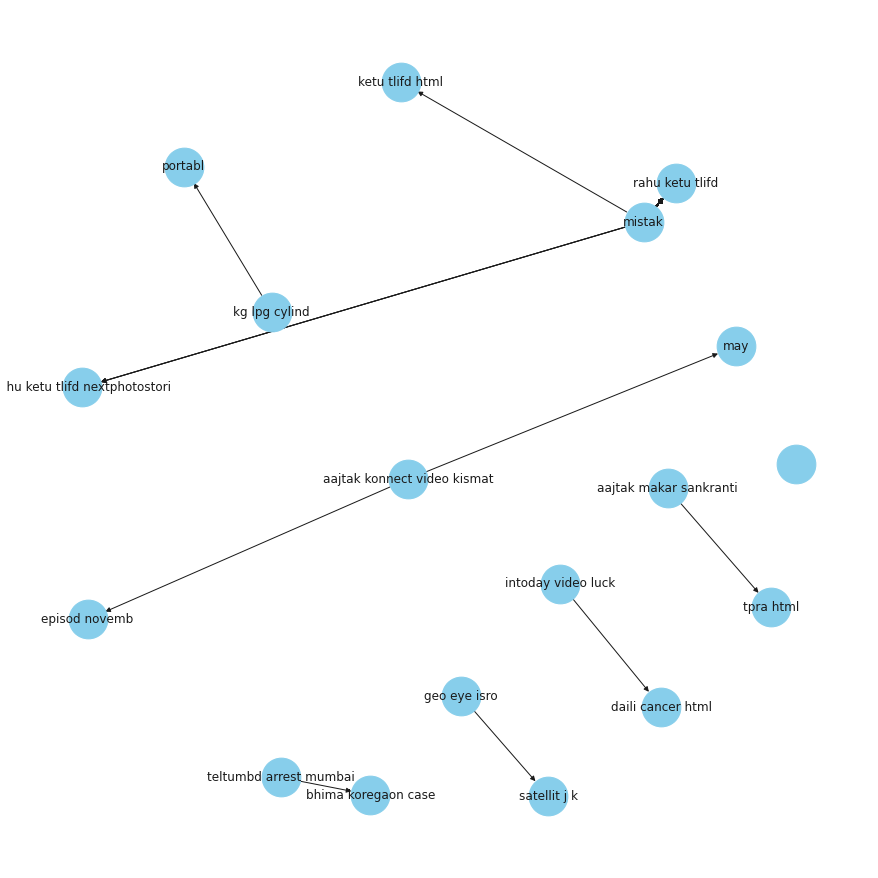

In [42]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="connect"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

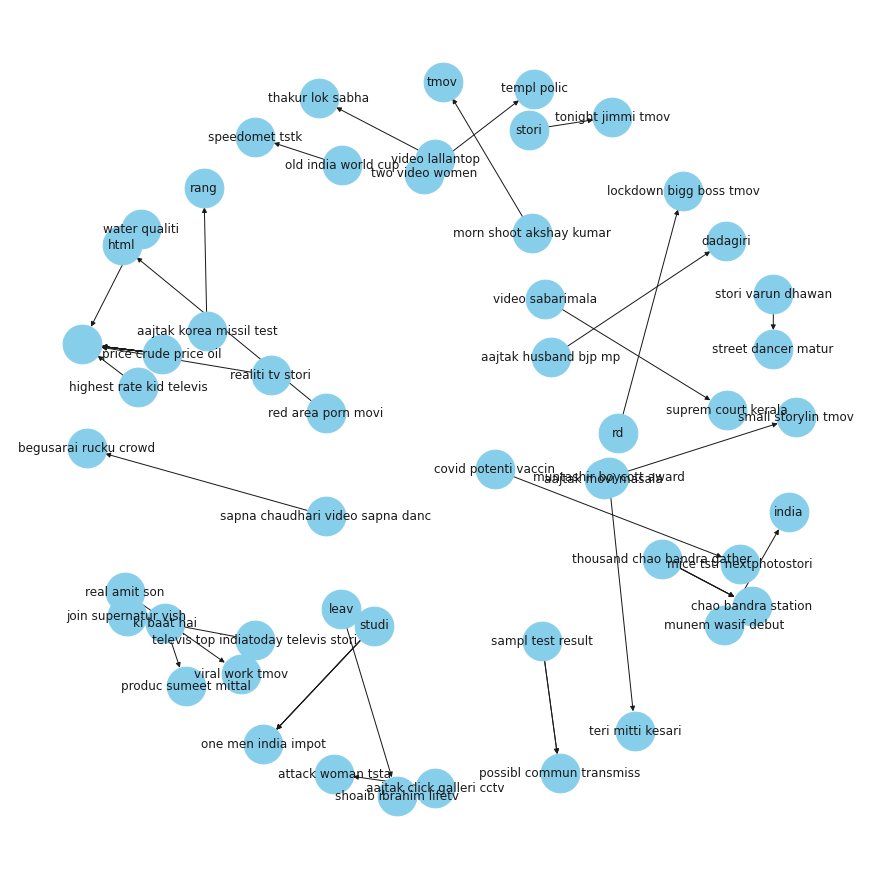

In [43]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="show"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) 
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

now let's map these with the color affinities based on the color preferences by gender and age group


In [45]:
kg_df.head(5)

,source,target,edge
0,cast base censu,,happen
1,aajtak video crime women,,stop
2,sapna chaudhari video sapna danc,begusarai rucku crowd,show
3,aajtak masala news film,remak jersey tmov,stori
4,aajtak konnect video kismat,episod novemb,connect


In [48]:
kg_df.shape

(99471, 3)

In [47]:
con.shape

(99471, 80)

In [49]:
con.columns

Index(['_index', '_type', '_id', '_score', 'publisher_id', 'date', 'country',
       'page_title', 'organisation', 'picture_jpg', 'incomelevel',
       'mastercookie_id', 'clickurloriginal', 'sourceUrl', 'top_url',
       'br_user_agent', 'refcurrent', 'refcurrentoriginal', 'canvas_installed',
       'clickedurl', 'sessionhash', 'screen_resoln', 'audience_segment', 'id',
       'state', 'QuarterValue', 'page_meta_tag', 'brandName', 'reforiginal',
       'ip', 'picture_gif', 'font_installed', 'cookie_id', 'cookiehash',
       'browser_name', 'fingerprint_id', 'gif_animated', 'localStoragecuid',
       'system_os', 'subcategory', 'dual_orientation', 'channel_id',
       'parameters', 'device', 'picture_png', 'streaming_mov',
       'engagementTime', 'gender', 'city', 'hotspot', 'visitor_id', 'agegroup',
       'colors', 'request_time', 'referrerType', 'hseries', 'channel_name',
       'streaming_mp4', 'publisher_name', 'ISP', 'session_id', 'time_zone',
       'installed_activex', 'resolu

In [50]:
con.gender.value_counts()

male            52158
female          46674
Undetermined      639
Name: gender, dtype: int64

In [54]:
con.agegroup.value_counts()

35_44           23593
25_34           20613
18_24           19157
45_54           18220
13_17           17374
Undetermined      514
Name: agegroup, dtype: int64

In [199]:
new= con[["agegroup","gender"]]

In [200]:
concat= pd.concat([kg_df,new], axis=1)

In [201]:
concat.head()

,source,target,edge,agegroup,gender
0,cast base censu,,happen,25_34,female
1,aajtak video crime women,,stop,45_54,male
2,sapna chaudhari video sapna danc,begusarai rucku crowd,show,45_54,male
3,aajtak masala news film,remak jersey tmov,stori,35_44,male
4,aajtak konnect video kismat,episod novemb,connect,45_54,female


In [202]:
concat.dtypes

source      object
target      object
edge        object
agegroup    object
gender      object
dtype: object

Data Preprocessing

In [203]:
from sklearn.preprocessing import LabelEncoder

In [204]:
lr= LabelEncoder()

In [205]:
concat["agegroup"]= concat["agegroup"].astype("str")

In [206]:
concat["age"]= lr.fit_transform(concat.agegroup)

In [207]:
concat["gender"]= concat["gender"].astype("str")

In [208]:
concat["gend"]= lr.fit_transform(concat.gender)

In [209]:
concat.head()

,source,target,edge,agegroup,gender,age,gend
0,cast base censu,,happen,25_34,female,2,1
1,aajtak video crime women,,stop,45_54,male,4,2
2,sapna chaudhari video sapna danc,begusarai rucku crowd,show,45_54,male,4,2
3,aajtak masala news film,remak jersey tmov,stori,35_44,male,3,2
4,aajtak konnect video kismat,episod novemb,connect,45_54,female,4,1


In [210]:
concat.gender.value_counts()

male            52158
female          46674
nan              7633
Undetermined      639
Name: gender, dtype: int64

In [211]:
concat.gend.value_counts()

2    52158
1    46674
3     7633
0      639
Name: gend, dtype: int64

In [212]:
concat.agegroup.value_counts()

35_44           23593
25_34           20613
18_24           19157
45_54           18220
13_17           17374
nan              7633
Undetermined      514
Name: agegroup, dtype: int64

In [213]:
concat.age.value_counts()

3    23593
2    20613
1    19157
4    18220
0    17374
6     7633
5      514
Name: age, dtype: int64

In [214]:
values = ['DenimBlue', 'CrimsonRed', 'QuartzSilver', 'CherryRed','PowderBlue','EmeraldGreen','MistyGray','PineGreen','PaleBeige','CrepePink', 'black','black_1']

In [215]:
conditions= [(concat["age"]==0) & (concat["gend"]==2), 
             (concat["age"]==0) & (concat["gend"]==1),
             (concat["age"]==1) & (concat["gend"]==2),
             (concat["age"]==1) & (concat["gend"]==1),
             (concat["age"]==2) & (concat["gend"]==2),
             (concat["age"]==2) & (concat["gend"]==1),
             (concat["age"]==3) & (concat["gend"]==2),
             (concat["age"]==3) & (concat["gend"]==1),
             (concat["age"]==4) & (concat["gend"]==2),
             (concat["age"]==4) & (concat["gend"]==1),
             (concat["gend"]==3), (concat["gend"]==0)]

In [216]:
import numpy as np

In [217]:
concat['coloraffinity'] = np.select(conditions, values)

In [218]:
concat.head()

,source,target,edge,agegroup,gender,age,gend,coloraffinity
0,cast base censu,,happen,25_34,female,2,1,EmeraldGreen
1,aajtak video crime women,,stop,45_54,male,4,2,PaleBeige
2,sapna chaudhari video sapna danc,begusarai rucku crowd,show,45_54,male,4,2,PaleBeige
3,aajtak masala news film,remak jersey tmov,stori,35_44,male,3,2,MistyGray
4,aajtak konnect video kismat,episod novemb,connect,45_54,female,4,1,CrepePink


In [219]:
concat.isna().sum()

source           7633
target           7633
edge             7633
agegroup            0
gender              0
age                 0
gend                0
coloraffinity       0
dtype: int64

dropping the nan columns

In [220]:
concat["source"]= concat.source.dropna()

In [221]:
concat.shape

(107104, 8)

In [222]:
concat.isna().sum()

source           7633
target           7633
edge             7633
agegroup            0
gender              0
age                 0
gend                0
coloraffinity       0
dtype: int64

In [223]:
concat.dropna(inplace=True, axis=0)

In [224]:
concat.isna().sum()

source           0
target           0
edge             0
agegroup         0
gender           0
age              0
gend             0
coloraffinity    0
dtype: int64

In [225]:
concat.shape

(99471, 8)

In [227]:
concat.to_csv("knowledge.csv")